# Advanced Usage

Topics:
* Features of **DynamicalSystems.jl** not covered in this tutorial series.
* Using the integrators
* An example of using `gali` with `integrators`

# Other Features
To keep this tutorial series within reasonable margins, some features were not covered but are of course present in the [official documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/).

These are:

1. [Neighborhood estimation of a dataset (using module `NearestNeighbors`)](https://juliadynamics.github.io/DynamicalSystems.jl/latest/definition/dataset/#neighborhoods-in-a-dataset) 
1. [Numerical computation of Lyapunov exponent from a dataset](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/nlts/#numerical-lyapunov-exponent)
1. [Broomhead-King coordinates](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/nlts/#broomhead-king-coordinates)
1. [Finding fixed points of any any order for a map](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/periodicity/)

# Using the integrators
**DynamicalSystems.jl** creates (and uses) various kinds of integrators:

In [9]:
using DynamicalSystems

In [2]:
?integrator

search: integrator tangent_integrator parallel_integrator



```
integrator(ds::DynamicalSystem [, u0]; diff_eq_kwargs) -> integ
```

Return an integrator object that can be used to evolve a system interactively using `step!(integ [, Δt])`. Optionally specify an initial state `u0`.

The state of this integrator is a vector.

See [`trajectory`](@ref) for `diff_eq_kwargs`.


In [3]:
?parallel_integrator

search: parallel_integrator



```
parallel_integrator(ds::DynamicalSystem, states; diff_eq_kwargs) -> integ
```

Return an integrator object that can be used to evolve many `states` of a system in parallel interactively using `step!(integ [, Δt])`.

The states of this integrator are a vector of vectors, each one being an actual state of the dynamical system. Only for the case of in-place continuous systems, the integrator propagates a matrix with each column being a state, because at the moment DifferentialEquations.jl does not support `Vector[Vector]` as state.

See [`trajectory`](@ref) for `diff_eq_kwargs`.


In [4]:
?tangent_integrator

search: tangent_integrator



```
tangent_integrator(ds::DynamicalSystem, Q0 | k::Int; u0, t0, diff_eq_kwargs)
```

Return an integrator object that evolves in parallel both the system as well as deviation vectors living on the tangent space.

`Q0` is a *matrix* whose columns are initial values for deviation vectors. If instead of a matrix `Q0` an integer `k` is given, then `k` random orthonormal vectors are choosen as initial conditions.

You can also give as a keyword argument a different initial state at time `u0, t0`.

The state of this integrator is a matrix with the first column the system state and all other columns being deviation vectors.

See [`trajectory`](@ref) for `diff_eq_kwargs`.

## Description

If $J$ is the jacobian of the system then the *tangent dynamics* are the equations that evolve in parallel the system as well as a deviation vector (or matrix) $w$:

$$
\begin{aligned}
\dot{u} &= f(u, p, t) \\
\dot{w} &= J(u, p, t) \times w
\end{aligned}
$$

with $f$ being the equations of motion and $u$ the system state. Similar equations hold for the discrete case.

Internally the integrator propagates a matrix, with the first column being the state and each subsequent one being a deviation vector.

See [`trajectory`](@ref) for `diff_eq_kwargs`.


---

---

These integrators work for *any* possible system allowed in **DynamicalSystems.jl** and special care has also been given in their performance. For this reason, the state type of each individual integrator can differ. Keep this in mind when using them!

---

---

All methods that use a `DynamicalSystem` internally create an instance of an `integrator`. If you want to run very costly computations on a cluster, it is best to use the low level methods that use an integrator, because they are more performant.

**Keep in mind that all integrators are `mutable` objects, while `DynamicalSystem` is immutable**. This means that if you want to *parallelize* something, using the integrators may lead to errors.

---

---

One handy thing for the integrators is the ability to "re-initialize" then in a new state, by simply using `reinit!(integrator, newstate)`. This is of course much more efficient than simply re-running the entire top-level function from scratch.

The performance gain is only small, but when each cluster hour costs you money, why not do it?

# An example of using `gali` with `integrators`

This example is taken directly from the documentation, and serves as a good indication of how to use the integrators.

Let's revisit the documentation string of `gali`:

In [5]:
?gali

search: gali generalized_dim eigvals eigvals! Diagonal global GlobalRef cglobal



```
gali(ds::DynamicalSystem, k::Int, tmax; kwargs...) -> GALI_k, t
```

Compute $\text{GALI}_k$ [1] for a given `k` up to time `tmax`. Return $\text{GALI}_k(t)$ and time vector $t$.

## Keyword Arguments

  * `threshold = 1e-12` : If `GALI_k` falls below the `threshold` iteration is terminated.
  * `dt = 1` : Time-step between variational vector normalizations. For continuous systems this is approximate.
  * `diff_eq_kwargs` : See [`trajectory`](@ref).
  * `u0` : Initial state for the system. Defaults to `state(ds)`.
  * `w0` : Initial orthonormal vectors (in matrix form). Defaults to `orthonormal(dimension(ds), k)`, i.e. `k` random orthonormal vectors.

## Description

The Generalized Alignment Index, $\text{GALI}_k$, is an efficient (and very fast) indicator of chaotic or regular behavior type in $D$-dimensional Hamiltonian systems ($D$ is number of variables). The *asymptotic* behavior of $\text{GALI}_k(t)$ depends critically of the type of orbit resulting from the initial condition `state(ds)`. If it is a chaotic orbit, then

$$
\text{GALI}_k(t) \sim
\exp\left[\sum_{j=1}^k (\lambda_1 - \lambda_j)t \right]
$$

with $\lambda_1$ being the maximum [`lyapunov`](@ref) exponent. If on the other hand the orbit is regular, corresponding to movement in $d$-dimensional torus with $1 \le d \le D/2$ then it holds

$$
\text{GALI}_k(t) \sim
    \begin{cases}
      \text{const.}, & \text{if} \;\; 2 \le k \le d  \; \; \text{and}
      \; \;d > 1 \\
      t^{-(k - d)}, & \text{if} \;\;  d < k \le D - d \\
      t^{-(2k - D)}, & \text{if} \;\;  D - d < k \le D
    \end{cases}
$$

Traditionally, if $\text{GALI}_k(t)$ does not become less than the `threshold` until `tmax` the given orbit is said to be chaotic, otherwise it is regular.

Our implementation is not based on the original paper, but rather in the method described in [2], which uses the product of the singular values of $A$, a matrix that has as *columns* the deviation vectors.

## Performance Notes

This function uses a [`tangent_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : Skokos, C. H. *et al.*, Physica D **231**, pp 30–54 (2007)

[2] : Skokos, C. H. *et al.*, *Chaos Detection and Predictability* - Chapter 5 (section 5.3.1 and ref. [85] therein), Lecture Notes in Physics **915**, Springer (2016)


---

You see that the docstring says:

> This function uses a `tangent_integrator`. For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

Let's use the `@which` command:

In [6]:
ds = Systems.standardmap(k=1.0)
@which gali(ds, 2, 1000)

gali(ds::DynamicalSystemsBase.DynamicalSystem{IIP,S,D,F,P,JAC,JM,IAD} where IAD where JM where JAC where P where F, k::Int64, tmax::Real) where {IIP, S, D} in ChaosTools at C:\Users\datseris\.julia\v0.6\ChaosTools\src\chaos_detection.jl:76

Clicking the link reveals that the low level method belongs to module `ChaosTools` and has call signature:
```julia
function _gali(tinteg, tmax, dt, threshold)
...
```

This is exactly the signature we will use!

**Please note: the following computation takes a couple of minutes!!!**

i = 20
i = 40
i = 60
i = 80
i = 100
i = 120
i = 140
i = 160
i = 180


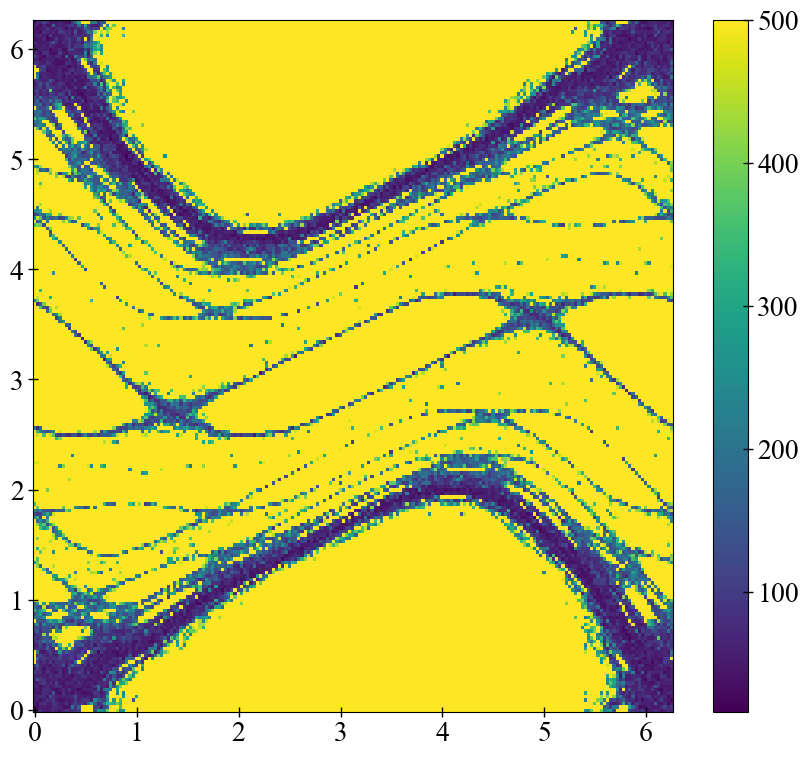

i = 200


In [7]:
using PyPlot, StaticArrays

function main(k)

    # Measure of chaoticity: final time of gali_2
    dens = 201
    chaoticity = zeros(Int, dens, dens)

    θs = ps = linspace(0, 2π, dens+1)
    ds = Systems.standardmap(k = k)

    tinteg = tangent_integrator(ds, 2)

    for (i, θ) ∈ enumerate(θs[1:dens])
        i % 20 == 0 && println("i = $(i)")
        for (j, p) ∈ enumerate(ps[1:dens])

            # new initial state is the system initial state
            # and 2 random orthonormal deviation vectors:
            u0 = hcat(SVector{2}(θ, p), orthonormal(2,2))
            reinit!(tinteg, u0)

            # Low-level call signature of gali:
            #  _gali(tinteg, tmax, dt, threshold)
            # necessary to preface it with ChaosTools.
            chaoticity[i, j] = ChaosTools._gali(tinteg, 500, 1, 1e-12)[2][end]
        end
    end

    pcolormesh(θs .- (θs[2] - θs[1])/2, ps .- (ps[2] - ps[1])/2,
    chaoticity')
    colorbar()

end

main(0.9);

In [8]:
ds = Systems.standardmap(k = 1)
tinteg = tangent_integrator(ds, 2)

using BenchmarkTools
# Benchmark for full function call
@btime gali(ds, 2, 500)

# Benchmark for chaotic
@btime ChaosTools._gali($tinteg, 500, 1, 1e-12)

u0 = hcat(SVector(π + 0.01*rand(), 0.01*rand()), orthonormal(2,2))
reinit!(tinteg, u0)
# benchmark for regular:
@btime ChaosTools._gali($tinteg, 500, 1, 1e-12);

# Benchmark for reinit! with a pre-computed state:
@btime reinit!($tinteg, $u0)

  143.360 μs (552 allocations: 66.00 KiB)
  5.689 μs (39 allocations: 3.59 KiB)
  1.193 ms (7540 allocations: 1.12 MiB)
  4.693 ns (0 allocations: 0 bytes)
